[2482, 1183] , [3854, 923] , [376, 825] , [2519, 135] , [2945, 1622] , [953, 268] , [2628, 1479] , [2097, 981] , [890, 1846] , [2139, 1806] , [2421, 1007] , [2290, 1810] , [1115, 1052] , [2588, 302] , [327, 265] , [241, 341] , [1917, 687] , [2991, 792] , [2573, 599] , [19, 674] , [3911, 1673] , [872, 1559] , [2863, 558] , [929, 1766] , [839, 620] , [3893, 102] , [2178, 1619] , [3822, 899] , [378, 1048] , [1178, 100] , [2599, 901] , [3416, 143] , [2961, 1605] , [611, 1384] , [3113, 885] , [2597, 1830] , [2586, 1286] , [161, 906] , [1429, 134] , [742, 1025] , [1625, 1651] , [1187, 706] , [1787, 1009] , [22, 987] , [3640, 43] , [3756, 882] , [776, 392] , [1724, 1642] , [198, 1810] , [3950, 1558] , 

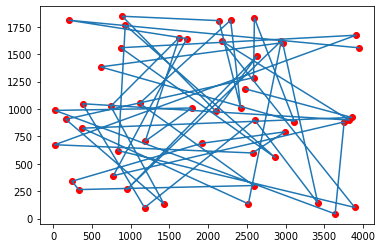

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 3677 (-1225) rows, 2499 (-51) columns and 14406 (-2450) elements
Clp1000I sum of infeasibilities 0.000111307 - average 3.02713e-08, 2321 fixed columns
Coin0506I Presolve 2458 (-1219) rows, 133 (-2366) columns and 5099 (-9307) elements
Clp0029I End of values pass after 133 iterations
Clp0014I Perturbing problem by 0.001% of 17.324788 - largest nonzero change 4.6669983e-05 ( 0.0025942629%) - largest zero change 2.8696192e-05
Clp0000I Optimal - objective value 115451
Clp0000I Optimal - objective value 115451
Coin0511I After Postsolve, objective 115451, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 0.99234818 - largest nonzero change 2.9638957e-05 ( 0.0014819478%) - largest zero change 2.7166095e-05
Clp0000I Optimal - objective value 115451
Clp0000I Optimal - objective value 11

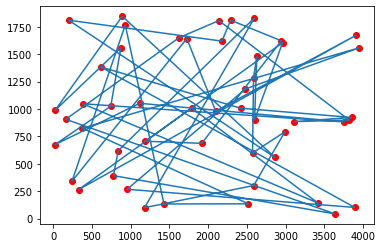

In [1]:
from mip import OptimizationStatus
from typing import Tuple, List
from math import floor, cos, acos
from itertools import product
from sys import stdout as out
import networkx as nx
from mip import Model, xsum, minimize, BINARY, ConstrsGenerator, CutPool
import matplotlib.pyplot as plt

PI, RRR = 3.141592, 6378.388

def rad(val: float) -> float:
    """converts to radians"""
    mult = 1.0
    if val < 0.0:
        mult = -1.0
        val = abs(val)

    deg = float(floor(val))
    minute = val - deg
    return (PI * (deg + 5 * minute / 3) / 180) * mult

def dist(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """computes geographical distance"""
    q1 = cos(p1[1] - p2[1])
    q2 = cos(p1[0] - p2[0])
    q3 = cos(p1[0] + p2[0])
    return int(floor(RRR * acos(0.5 * ((1.0 + q1) * q2 - (1.0 - q1) * q3)) + 1.0))

def draw(x,y):
    plt.plot(x, y)
    plt.scatter(x, y, c='r')
    plt.show()

# coordinates of ulysses22 tsplib instance
filename = 'Input.txt'

xx=[]
yy=[]
coord =[]
quantity_points = 0

#reading
with open(filename, 'r') as f:
    for line in f:
        if quantity_points == 0:
            quantity_points = int(line) 
        else:
            xx.append(int(line.split()[0]))
            yy.append(int(line.split()[1]))
            coord.append([int(line.split()[0]),int(line.split()[1])])

route = list(range(0,quantity_points - 1))

for c in coord:
    out.write("%s , " % c)
    
#input 
draw(xx,yy)

# latitude and longitude
coord = [(rad(x), rad(y)) for (x, y) in coord]

# number of nodes and list of arcs
n, V = len(coord), set(range(len(coord)))
Arcs = [(i, j) for (i, j) in product(V, V) if i != j]

# distances matrix
c = [[0 if i == j else dist(coord[i], coord[j]) for j in V] for i in V]

class SubTourCutGenerator(ConstrsGenerator):
    """Class to generate cutting planes for the TSP"""

    def __init__(self, Fl: List[Tuple[int, int]], x_):
        self.F, self.x = Fl, x_

    def generate_constrs(self, m_: Model, depth: int = 0, npass: int = 0):
        xf, cp, Gl = m_.translate(self.x), CutPool(), nx.DiGraph()
        Ar = [(i, j) for (i, j) in Arcs if xf[i][j] and xf[i][j].x >= 1e-4]
        for (u, v) in Ar:
            Gl.add_edge(u, v, capacity=xf[u][v].x)
        for (u, v) in F:
            val, (S, NS) = nx.minimum_cut(Gl, u, v)
            if val <= 0.99:
                aInS = [(xf[i][j], xf[i][j].x) for (i, j) in Ar if i in S and j in S]
                if sum(f for v, f in aInS) >= (len(S) - 1) + 1e-4:
                    cut = xsum(1.0 * v for v, fm in aInS) <= len(S) - 1
                    cp.add(cut)
                    if len(cp.cuts) > 32:
                        for cut in cp.cuts:
                            m_ += cut
                        return
        for cut in cp.cuts:
            m_ += cut

model = Model()

# binary variables indicating if arc (i,j) is used on the route or not
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# continuous variable to prevent subtours: each city will have a
# different sequential id in the planned route except the first one
y = [model.add_var() for i in V]

# objective function: minimize the distance
model.objective = minimize(xsum(c[i][j] * x[i][j] for (i, j) in Arcs))

# constraint : leave each city only once
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

# constraint : enter each city only once
for i in V:
    model += xsum(x[j][i] for j in V - {i}) == 1

# (weak) subtour elimination constraints
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[i] - (n + 1) * x[i][j] >= y[j] - n

# degree 2 subtour elimination constraints
for (i, j) in Arcs:
    model += x[i][j] + x[j][i] <= 1


# list of distant nodes to check for disconected subtours
F, G = [], nx.DiGraph()
for (i, j) in Arcs:
    G.add_edge(i, j, weight=c[i][j])
for i in V:
    P, D = nx.dijkstra_predecessor_and_distance(G, source=i)
    DS = list(D.items())
    DS.sort(key=lambda x: x[1])
    F.append((i, DS[-1][0]))

model.cuts_generator = SubTourCutGenerator(F, x)

# optimizing
model.optimize()
    
string = '0 '
nx = []
ny = []
nroute = []
nroute.append(0)

# checking if a solution was found
if model.num_solutions:
    out.write(
        "route with total distance %g found: %s" % (model.objective_value, 0)
    )
    nc = 0
    while True:
        nc = [i for i in V if x[nc][i].x >= 0.99][0]
        out.write(" -> %s" % nc) 
        string += str(nc) + ' '
        nroute.append(nc)
        if nc == 0:
            break
    out.write("\n")

#writing output
f = open('Output.txt', 'w')
f.write(str(model.objective_value)+'\n')
f.write(string)
f.close()

for i in nroute:
    out.write("%s , " % str(i))
    nx.append(xx[i])
    ny.append(yy[i])

draw(nx,ny)